## Movie Greenlighting Tool 

***Author:*** Diogo Maio Gonçalves
diogomaiog@gmail.com

Final project for Data analytics bootcamp @Ironhack Lisbon

December 2020

In [258]:
#libraries used
import time
import pandas as pd
import pickle
import requests
from bs4 import BeautifulSoup
from scrapy import Selector
import threading
import multiprocessing
import csv
import regex as re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import winsound
from xgboost import XGBClassifier



[nltk_data] Downloading package punkt to C:\Users\Diogo
[nltk_data]     Gonçalves\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Diogo Gonçalves\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Diogo
[nltk_data]     Gonçalves\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Diogo
[nltk_data]     Gonçalves\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# getting and checking contents of IMDB datasets

# following this https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5

# I downloaded all the tables in https://www.imdb.com/interfaces/ except the  “title.episode.tsv.gz” as 
# I am interested in movies in the notebook, not TV series.

# list file paths
path = 'Data/'
tsv_files = [path + 'name.basics.tsv.gz',
             path + 'title.akas.tsv.gz',
             path + 'title.basics.tsv.gz',
             path + 'title.crew.tsv.gz',
             path + 'title.principals.tsv.gz',
             path + 'title.ratings.tsv.gz']


# save all tables one by one into separate sav files (to save time loading them later)
for file in tsv_files:
     print(file)
     pickle.dump(pd.read_table(file,sep="\t",low_memory=False, na_values=["\\N","nan"]),
                 open(file[:-7]+".sav","wb"))


Data/name.basics.tsv.gz
Data/title.akas.tsv.gz
Data/title.basics.tsv.gz
Data/title.crew.tsv.gz
Data/title.principals.tsv.gz
Data/title.ratings.tsv.gz


In [2]:
path = 'Data/'
df_basics = pickle.load(open(path+"title.basics.sav","rb"))
df = df_basics[df_basics['titleType']=='movie']
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894.0,NaN,45,Romance
331,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900.0,NaN,NaN,"Biography,Drama"
498,tt0000502,movie,Bohemios,Bohemios,0,1905.0,NaN,100,NaN
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906.0,NaN,70,"Biography,Crime,Drama"
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907.0,NaN,NaN,Drama


In [3]:
# I'll try to get the 1)financial data and 2)synopsis from each movie page, that way i won't have so many problems 
# matching titles as if I scrapped the info form some other website

# let's try with a single page
url = 'https://www.imdb.com/title/tt0082971/'
request = requests.get(url)
html = request.content
soup = BeautifulSoup(html)
soup

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="app-id=342792525, app-argument=imdb:///title/tt0082971?src=mdot" name="apple-itunes-app"/>
<script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
</script>
<script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
<title>Os Salteadores da Arca Perdida (1981) - IMDb</title>
<script>(function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);</script>
<script>
    if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
</script>
<script>
    if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});
    }
</script>
<link href=

In [4]:
# saving the storyline
story = soup.find('div',{'class':'inline canwrap'}).find('span').get_text().strip()
story

'The year is 1936. An archeology professor named Indiana Jones is venturing in the jungles of South America searching for a golden statue. Unfortunately, he sets off a deadly trap but miraculously escapes. Then, Jones hears from a museum curator named Marcus Brody about a biblical artifact called The Ark of the Covenant, which can hold the key to humanly existence. Jones has to venture to vast places such as Nepal and Egypt to find this artifact. However, he will have to fight his enemy Rene Belloq and a band of Nazis in order to reach it.'

In [5]:
# saving the budget and cumulative worldwide gross
#titleDetails = soup.find('div',{'id':'titleDetails'})
#titleDetails.find_all('div', class_='txt-block')

#res = requests.get(url)
res = request
sel = Selector(res)
budget = ' '.join(sel.css(".txt-block:contains('Budget')::text").extract()).strip()
gross = ' '.join(sel.css(".txt-block:contains('Gross USA')::text").extract()).strip()
cumulative = ' '.join(sel.css(".txt-block:contains('Cumulative Worldwide')::text").extract()).strip()
print(f'budget: {budget}\ngross: {gross}\ncumulative: {cumulative}')



budget: $18,000,000
gross: $248,159,971
cumulative: $389,925,971


In [3]:
# ok, it's time to get my ip banned

# I'll start by reducing the scope to only movies made since 1980, if that goes fast I'll try to get older info
df80 = df[df['startYear'] > 1979]

In [4]:
# turns out scrapping 330k movies takes some days using my current method. I need to make the list shorter
# let's drop rows without 'runtimeMinutes'
df80 = df80.dropna(subset=['runtimeMinutes']) #this drops aroun 78k rows, nice

# let's drop all movies less than 70 min long
df80['runtimeMinutes'] = df80['runtimeMinutes'].astype(int)
df80 = df80[df80['runtimeMinutes']>=70] #this step removes an additional 50k

In [5]:
# I want to create a list of all IMDB movies URLs (I plan to scrape some additional inofrmation later)
prefix = 'https://www.imdb.com/title/'
movies_url = [prefix + idcon for idcon in df80['tconst']]
movies_url[0]

'https://www.imdb.com/title/tt0015724'

In [142]:
def get_details(movies_url):
    '''
    For a given list of IMDB movies URLs returns list containing the URL, Storyline, 
    Budget, Gross USA, Cumulative Worldwide Gross
    '''
    #start = time.perf_counter()
    story = []
    budget = []
    gross = []
    cumulative = []

    for url in movies_url:
        print(url)
        request = requests.get(url)
        html = request.content
        soup = BeautifulSoup(html)
        try:
#            story.append(soup.find('div',{'class':'inline canwrap'}).find('span').get_text().strip())
            story = soup.find('div',{'class':'inline canwrap'}).find('span').get_text().strip()
        except:
            pass
        res = request
        sel = Selector(res)
        try:
#            budget.append(' '.join(sel.css(".txt-block:contains('Budget')::text").extract()).strip())
            budget = ' '.join(sel.css(".txt-block:contains('Budget')::text").extract()).strip()
        except:
            pass
        try:
#            gross.append(' '.join(sel.css(".txt-block:contains('Gross USA')::text").extract()).strip())
            gross = ' '.join(sel.css(".txt-block:contains('Gross USA')::text").extract()).strip()
        except:
            pass
        try:
#            cumulative.append(' '.join(sel.css(".txt-block:contains('Cumulative Worldwide')::text").extract()).strip())
            cumulative = ' '.join(sel.css(".txt-block:contains('Cumulative Worldwide')::text").extract()).strip()

        except:
            pass
        try:
            rating = soup.find("div",{'class':'subtext'}).contents[0].string.strip()        
        except:
            pass
        row = [url,story,budget,gross,cumulative,rating]
#        with csv_writer_lock:
        with open("movie_details.csv", mode="a") as f1:
            details_writer = csv.writer(f1, delimiter=",")
            details_writer.writerow(row)
    return row

    #details = pd.DataFrame()
    #details['url'] = movies_url
    #details['story'] = story
    #details['budget'] = budget
    #details['gross'] = gross
    #details['cumulative'] = cumulative
    #finish = time.perf_counter()
    #print('finished in '+str(finish-start)+' seconds')
    #return details

#csv_writer_lock = threading.Lock()
#details = get_details(movies_url[:20])

get_details(['https://www.imdb.com/title/tt0097576/'])

https://www.imdb.com/title/tt0097576/


['https://www.imdb.com/title/tt0097576/',
 'An art collector appeals to Indiana Jones to embark on a search for the Holy Grail. He learns that another archaeologist has disappeared while searching for the precious goblet, and the missing man is his own father, Dr. Henry Jones. The artifact is much harder to find than they expected, and its powers are too much for those impure of heart.',
 '$48,000,000',
 '$197,171,806',
 '$474,171,806',
 'M/12']

In [6]:
 len(movies_url)

203148

In [14]:
type (movies_url[0])

str

In [16]:
# doing this without paralelization makes the task take too long. I would need more than a week to scrape
# I started by restricting the movies that get into my movies_url list
# I may need to go further, and select only us made movies, or reduce the timeframe 
# I can't get pararelization to work on jupyter, I'll do it in google collab
# I need to export the list of movies to scrape
with open('movies_url.pkl', 'wb') as f:
    pickle.dump(movies_url, f)

In [ ]:
'''
!!! END OF SCRAPPING !!!
'''




In [2]:
# I will now import the result of the scraping done in g. collab
# the scrapping takes around 8 hours, I may include data for aditional decades later
dfs = pd.read_csv('Data/movie_details.csv', names=['url','story','budget','gross','cumulative','rating'])
dfs.head()

,url,story,budget,gross,cumulative,rating
0,https://www.imdb.com/title/tt0080933,A biological experiment in Florida goes awry. ...,"$3,500,000",NaN,NaN,Not Rated
1,https://www.imdb.com/title/tt0080803,A large quantity of gold is stolen from the go...,NaN,NaN,NaN,NaN
2,https://www.imdb.com/title/tt0080522,NaN,NaN,NaN,NaN,NaN
3,https://www.imdb.com/title/tt0078202,NaN,NaN,NaN,NaN,NaN
4,https://www.imdb.com/title/tt0015724,NaN,NaN,NaN,NaN,NaN


In [3]:
dfs.shape

(204148, 6)

In [4]:
dfs.dropna().shape

(8093, 6)

In [5]:
# For now I'll drop any row with missing values
dfs.dropna(inplace = True)

dfs.head()

,url,story,budget,gross,cumulative,rating
5,https://www.imdb.com/title/tt0080661,"While taking a shower, Kate Miller, a middle-a...","$6,500,000","$31,899,000","$31,899,000",R
14,https://www.imdb.com/title/tt0080934,"In New York City, journalist Blair Maynard con...","$22,000,000","$15,716,828","$15,716,828",R
27,https://www.imdb.com/title/tt0035423,Kate and her actor brother live in N.Y. in the...,"$48,000,000","$47,121,859","$76,019,048",PG-13
34,https://www.imdb.com/title/tt0081249,An unknown terrorist has developed a new type ...,"$15,000,000","$14,662,035","$14,662,035",PG
35,https://www.imdb.com/title/tt0079285,Two lovers stationed at a remote base in the a...,"GBP10,000,000","$9,000,000","$9,000,000",R


In [6]:
print(dfs.shape)
print(dfs.drop_duplicates(subset=['url']).shape)

(8093, 6)
(8044, 6)


In [7]:
# remove rows with duplicate ids
dfs.drop_duplicates(subset=['url'],inplace=True)

In [8]:
# get id from url to be able to merge with the downloaded datasets later
def get_id(row):
    '''
    strips the last 9 chars of row['url'] to return the ID
    '''
    return str(row['url'])[-9:]

dfs['id'] = dfs.apply(lambda row: get_id(row), axis = 1)
dfs.head()

,url,story,budget,gross,cumulative,rating,id
5,https://www.imdb.com/title/tt0080661,"While taking a shower, Kate Miller, a middle-a...","$6,500,000","$31,899,000","$31,899,000",R,tt0080661
14,https://www.imdb.com/title/tt0080934,"In New York City, journalist Blair Maynard con...","$22,000,000","$15,716,828","$15,716,828",R,tt0080934
27,https://www.imdb.com/title/tt0035423,Kate and her actor brother live in N.Y. in the...,"$48,000,000","$47,121,859","$76,019,048",PG-13,tt0035423
34,https://www.imdb.com/title/tt0081249,An unknown terrorist has developed a new type ...,"$15,000,000","$14,662,035","$14,662,035",PG,tt0081249
35,https://www.imdb.com/title/tt0079285,Two lovers stationed at a remote base in the a...,"GBP10,000,000","$9,000,000","$9,000,000",R,tt0079285


In [9]:
# I'll drop url, it's redundant now
dfs.drop(columns=['url'], inplace = True)
dfs.head()

,story,budget,gross,cumulative,rating,id
5,"While taking a shower, Kate Miller, a middle-a...","$6,500,000","$31,899,000","$31,899,000",R,tt0080661
14,"In New York City, journalist Blair Maynard con...","$22,000,000","$15,716,828","$15,716,828",R,tt0080934
27,Kate and her actor brother live in N.Y. in the...,"$48,000,000","$47,121,859","$76,019,048",PG-13,tt0035423
34,An unknown terrorist has developed a new type ...,"$15,000,000","$14,662,035","$14,662,035",PG,tt0081249
35,Two lovers stationed at a remote base in the a...,"GBP10,000,000","$9,000,000","$9,000,000",R,tt0079285


In [10]:
# get the currency of the budget and cumulative gross before cleaning string 
def get_currency(row, column):
    '''
    returns the currency in a given column
    '''
    if str(row[column])[0] == '$':
        return 'USD'
    else:
        return str(row[column])[:3]

dfs['budget_cy'] = dfs.apply(lambda row: get_currency(row,'budget'), axis = 1)
dfs['gross_cy'] = dfs.apply(lambda row: get_currency(row,'gross'), axis = 1)
dfs['cumulative_cy'] = dfs.apply(lambda row: get_currency(row,'cumulative'), axis = 1)
dfs.head()

,story,budget,gross,cumulative,rating,id,budget_cy,gross_cy,cumulative_cy
5,"While taking a shower, Kate Miller, a middle-a...","$6,500,000","$31,899,000","$31,899,000",R,tt0080661,USD,USD,USD
14,"In New York City, journalist Blair Maynard con...","$22,000,000","$15,716,828","$15,716,828",R,tt0080934,USD,USD,USD
27,Kate and her actor brother live in N.Y. in the...,"$48,000,000","$47,121,859","$76,019,048",PG-13,tt0035423,USD,USD,USD
34,An unknown terrorist has developed a new type ...,"$15,000,000","$14,662,035","$14,662,035",PG,tt0081249,USD,USD,USD
35,Two lovers stationed at a remote base in the a...,"GBP10,000,000","$9,000,000","$9,000,000",R,tt0079285,GBP,USD,USD


In [11]:
dfs = dfs[dfs['id']!='tt0107492'] # Iknow this row has text on the budget column for some reason, I have to drop it

In [12]:
# now I'll clean the strings in budget and cumulative to get the numbers

def get_number(row, column):
        try:
            return int(re.sub("[^0-9]", "", str(row[column])))
        except:
            print(row['id'])
dfs['budget'] = dfs.apply(lambda row: get_number(row,'budget'), axis = 1)
dfs['gross'] = dfs.apply(lambda row: get_number(row,'gross'), axis = 1)
dfs['cumulative'] = dfs.apply(lambda row: get_number(row,'cumulative'), axis = 1)
dfs.head()

,story,budget,gross,cumulative,rating,id,budget_cy,gross_cy,cumulative_cy
5,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,USD,USD
14,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,USD,USD
27,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,USD,USD
34,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,USD,USD
35,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,USD,USD


In [13]:
dfs.dtypes

story            object
budget            int64
gross             int64
cumulative        int64
rating           object
id               object
budget_cy        object
gross_cy         object
cumulative_cy    object
dtype: object

In [14]:
# Besides deciding if to convert budget_cy to USD or just dropping rows with different currencies, 
# I have to decide if I want to use gross us or not. When I have the full dataset it will be easier to decide
dfs.groupby('budget_cy').count()

,story,budget,gross,cumulative,rating,id,gross_cy,cumulative_cy
budget_cy,,,,,,,,
ARS,2,2,2,2,2,2,2,2
ATS,1,1,1,1,1,1,1,1
AUD,33,33,33,33,33,33,33,33
BEF,1,1,1,1,1,1,1,1
BRL,10,10,10,10,10,10,10,10
Bud,1,1,1,1,1,1,1,1
CAD,74,74,74,74,74,74,74,74
CHF,2,2,2,2,2,2,2,2
CLP,1,1,1,1,1,1,1,1


In [15]:
# let's start to create the final table(s)
# I think I need at least two tables, one with the movie data, and other for actors
# for now, I'll work on the movie data one

In [16]:
# let's merge and create the main movies dataframe

In [17]:
# merging with title.basics
path='Data/'
movies = pd.merge(dfs,pickle.load(open(path+"title.basics.sav","rb")),left_on='id',right_on='tconst')
movies.head()

,story,budget,gross,cumulative,rating,id,budget_cy,gross_cy,cumulative_cy,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,USD,USD,tt0080661,movie,Dressed to Kill,Dressed to Kill,0,1980.0,NaN,104,"Crime,Drama,Mystery"
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,USD,USD,tt0080934,movie,The Island,The Island,0,1980.0,NaN,109,"Action,Adventure,Drama"
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,USD,USD,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,USD,USD,tt0081249,movie,The Nude Bomb,The Nude Bomb,0,1980.0,NaN,94,"Action,Comedy,Crime"
4,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,USD,USD,tt0079285,movie,Saturn 3,Saturn 3,0,1980.0,NaN,96,"Adventure,Horror,Sci-Fi"


In [18]:
movies.shape

(8031, 18)

In [19]:
print(movies.shape)
print(movies.drop_duplicates(subset=['id']).shape)

(8031, 18)
(8031, 18)


In [20]:
movies.drop(columns=['endYear','originalTitle','titleType','tconst','isAdult'], inplace = True)
movies.head()


,story,budget,gross,cumulative,rating,id,budget_cy,gross_cy,cumulative_cy,primaryTitle,startYear,runtimeMinutes,genres
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,USD,USD,Dressed to Kill,1980.0,104,"Crime,Drama,Mystery"
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,USD,USD,The Island,1980.0,109,"Action,Adventure,Drama"
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,USD,USD,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance"
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,USD,USD,The Nude Bomb,1980.0,94,"Action,Comedy,Crime"
4,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,USD,USD,Saturn 3,1980.0,96,"Adventure,Horror,Sci-Fi"


In [21]:
movies = pd.merge(movies,pickle.load(open(path+"title.ratings.sav","rb")),left_on='id',right_on='tconst')
movies.head()

,story,budget,gross,cumulative,rating,id,budget_cy,gross_cy,cumulative_cy,primaryTitle,startYear,runtimeMinutes,genres,tconst,averageRating,numVotes
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,USD,USD,Dressed to Kill,1980.0,104,"Crime,Drama,Mystery",tt0080661,7.1,34936
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,USD,USD,The Island,1980.0,109,"Action,Adventure,Drama",tt0080934,5.3,3789
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,USD,USD,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",tt0035423,6.4,78453
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,USD,USD,The Nude Bomb,1980.0,94,"Action,Comedy,Crime",tt0081249,5.2,2988
4,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,USD,USD,Saturn 3,1980.0,96,"Adventure,Horror,Sci-Fi",tt0079285,5.2,8291


In [22]:
movies.drop(columns=['tconst'], inplace = True)


In [23]:
movies = pd.merge(movies,pickle.load(open(path+"title.crew.sav","rb")),left_on='id',right_on='tconst')
movies.shape

(8030, 18)

In [24]:
movies.head()

,story,budget,gross,cumulative,rating,id,budget_cy,gross_cy,cumulative_cy,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,tconst,directors,writers
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,USD,USD,Dressed to Kill,1980.0,104,"Crime,Drama,Mystery",7.1,34936,tt0080661,nm0000361,nm0000361
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,USD,USD,The Island,1980.0,109,"Action,Adventure,Drama",5.3,3789,tt0080934,nm0006916,nm0001940
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,USD,USD,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,78453,tt0035423,nm0003506,"nm0737216,nm0003506"
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,USD,USD,The Nude Bomb,1980.0,94,"Action,Comedy,Crime",5.2,2988,tt0081249,nm0232795,"nm0000316,nm0377750,nm0838441,nm0199049,nm0827767"
4,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,USD,USD,Saturn 3,1980.0,96,"Adventure,Horror,Sci-Fi",5.2,8291,tt0079285,"nm0058045,nm0002045","nm0025007,nm0058045"


In [25]:
movies.drop(columns=['writers','tconst'], inplace = True)
movies.shape

(8030, 16)

In [26]:
movies.head()

,story,budget,gross,cumulative,rating,id,budget_cy,gross_cy,cumulative_cy,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,USD,USD,Dressed to Kill,1980.0,104,"Crime,Drama,Mystery",7.1,34936,nm0000361
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,USD,USD,The Island,1980.0,109,"Action,Adventure,Drama",5.3,3789,nm0006916
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,USD,USD,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,78453,nm0003506
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,USD,USD,The Nude Bomb,1980.0,94,"Action,Comedy,Crime",5.2,2988,nm0232795
4,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,USD,USD,Saturn 3,1980.0,96,"Adventure,Horror,Sci-Fi",5.2,8291,"nm0058045,nm0002045"


In [27]:
principals = pickle.load(open(path+"title.principals.sav","rb"))

In [28]:
principals[principals['tconst']=='tt0076759']

,tconst,ordering,nconst,category,job,characters
647896,tt0076759,10,nm0156816,editor,film editor,NaN
647897,tt0076759,1,nm0000434,actor,NaN,"[""Luke Skywalker""]"
647898,tt0076759,2,nm0000148,actor,NaN,"[""Han Solo""]"
647899,tt0076759,3,nm0000402,actress,NaN,"[""Princess Leia Organa""]"
647900,tt0076759,4,nm0000027,actor,NaN,"[""Ben Obi-Wan Kenobi""]"
647901,tt0076759,5,nm0000184,director,NaN,NaN
647902,tt0076759,6,nm0476030,producer,producer,NaN
647903,tt0076759,7,nm0564768,producer,producer,NaN
647904,tt0076759,8,nm0002354,composer,NaN,NaN
647905,tt0076759,9,nm0852405,cinematographer,director of photography,NaN


In [29]:
#let's select only top 3 billed, and drop the rest
principals = principals[(principals['ordering']<=3)&((principals['category']=='actor')|(principals['category']=='actress'))]
principals.head()

,tconst,ordering,nconst,category,job,characters
11,tt0000005,1,nm0443482,actor,NaN,"[""Blacksmith""]"
12,tt0000005,2,nm0653042,actor,NaN,"[""Assistant""]"
16,tt0000007,1,nm0179163,actor,NaN,NaN
17,tt0000007,2,nm0183947,actor,NaN,NaN
21,tt0000008,1,nm0653028,actor,NaN,"[""Sneezing Man""]"


In [30]:
#let's build a pivot table where the index is tconst, columns are category, and values are nconst 
# agreggated by concat or sum, or better yet with a function that puts a comma in between

def commatose(array):
    '''
    takes an array of strings and returns a string split by comma
    '''
    s = ""
    for i in array:
        if s != '':
            s = s + ',' + i
        else:
            s = i
    return s

principals = pd.pivot_table(principals, values = 'nconst', index = 'tconst', aggfunc = commatose)
principals.head()

,nconst
tconst,
tt0000005,"nm0443482,nm0653042"
tt0000007,"nm0179163,nm0183947"
tt0000008,nm0653028
tt0000009,"nm0063086,nm0183823,nm1309758"
tt0000011,nm3692297


In [31]:
movies.head()

,story,budget,gross,cumulative,rating,id,budget_cy,gross_cy,cumulative_cy,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,USD,USD,Dressed to Kill,1980.0,104,"Crime,Drama,Mystery",7.1,34936,nm0000361
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,USD,USD,The Island,1980.0,109,"Action,Adventure,Drama",5.3,3789,nm0006916
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,USD,USD,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,78453,nm0003506
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,USD,USD,The Nude Bomb,1980.0,94,"Action,Comedy,Crime",5.2,2988,nm0232795
4,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,USD,USD,Saturn 3,1980.0,96,"Adventure,Horror,Sci-Fi",5.2,8291,"nm0058045,nm0002045"


In [32]:
print(movies.shape)
movies = pd.merge(movies,principals,left_on='id',right_on='tconst')
print(movies.shape)
movies.head()

(8030, 16)
(7859, 17)


,story,budget,gross,cumulative,rating,id,budget_cy,gross_cy,cumulative_cy,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,nconst
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,USD,USD,Dressed to Kill,1980.0,104,"Crime,Drama,Mystery",7.1,34936,nm0000361,"nm0000323,nm0001141,nm0000262"
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,USD,USD,The Island,1980.0,109,"Action,Adventure,Drama",5.3,3789,nm0006916,"nm0000323,nm0001831,nm0700574"
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,USD,USD,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,78453,nm0003506,"nm0000212,nm0413168,nm0000630"
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,USD,USD,The Nude Bomb,1980.0,94,"Action,Comedy,Crime",5.2,2988,nm0232795,"nm0010915,nm0397109,nm0000482"
4,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,USD,USD,Saturn 3,1980.0,96,"Adventure,Horror,Sci-Fi",5.2,8291,"nm0058045,nm0002045","nm0000396,nm0000018,nm0000172"


In [33]:
#split nconst(top 3 listed actors of the movie) into 3 columns

def split_nconst(row):
    """
    splits the contents of column nconst for a given row, returning a list
    the list will allway have three elements
    """
    l = str(movies['nconst'][movies['id']==row['id']].tolist()[0]).split(",")
    if len(l) <3:
        if len(l) == 2:
            l.append('')
        if len(l) == 1:
            l.append('')
            l.append('')
    return l
    
movies['actor1'] = movies.apply(lambda row: split_nconst(row)[0], axis = 1)
movies['actor2'] = movies.apply(lambda row: split_nconst(row)[1], axis = 1)
movies['actor3'] = movies.apply(lambda row: split_nconst(row)[2], axis = 1)

In [34]:
# saving a copy, just in case
pickle.dump(movies,open('movies.pkl',"wb"))


In [456]:
"""
!!! THIS SAVES TIME !!!





!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
"""

movies = pickle.load(open('movies.pkl',"rb"))

In [457]:
# Time to start cleaning this table up
# I'll keep just one of the directors
def one_director(row):
    return str(movies['directors'][movies['id']==row['id']].tolist()[0]).split(",")[0]

movies['directors'] = movies.apply(lambda row: one_director(row), axis = 1)
movies.head()

,story,budget,gross,cumulative,rating,id,budget_cy,gross_cy,cumulative_cy,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,nconst,actor1,actor2,actor3
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,USD,USD,Dressed to Kill,1980.0,104,"Crime,Drama,Mystery",7.1,34936,nm0000361,"nm0000323,nm0001141,nm0000262",nm0000323,nm0001141,nm0000262
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,USD,USD,The Island,1980.0,109,"Action,Adventure,Drama",5.3,3789,nm0006916,"nm0000323,nm0001831,nm0700574",nm0000323,nm0001831,nm0700574
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,USD,USD,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,78453,nm0003506,"nm0000212,nm0413168,nm0000630",nm0000212,nm0413168,nm0000630
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,USD,USD,The Nude Bomb,1980.0,94,"Action,Comedy,Crime",5.2,2988,nm0232795,"nm0010915,nm0397109,nm0000482",nm0010915,nm0397109,nm0000482
4,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,USD,USD,Saturn 3,1980.0,96,"Adventure,Horror,Sci-Fi",5.2,8291,nm0058045,"nm0000396,nm0000018,nm0000172",nm0000396,nm0000018,nm0000172


In [458]:
# counting all NaN in df
len(movies) - movies.count()

story             0
budget            0
gross             0
cumulative        0
rating            0
id                0
budget_cy         0
gross_cy          0
cumulative_cy     0
primaryTitle      0
startYear         0
runtimeMinutes    0
genres            1
averageRating     0
numVotes          0
directors         0
nconst            0
actor1            0
actor2            0
actor3            0
dtype: int64

In [459]:
movies.dropna(inplace=True)

In [460]:
# time to drop come useless columns, like nconst (redundant, I have the names), 'primaryTitle' (I won't use it in the model)
# gross an cumulative currency beacause it's always USD
#movies.gross_cy.unique()
#movies.cumulative_cy.unique()

movies.drop(columns=['nconst','primaryTitle', 'gross_cy', 'cumulative_cy'], inplace = True)


In [461]:
# let's one-hot encode genres
# to save time I'll try to use a count vectorizer from NLP class
from sklearn.feature_extraction.text import CountVectorizer
bow_vect = CountVectorizer()

#splitting contents of genre column into list of strings
def split_genre(row):
    return row['genres'].split(',')

movies['genres'] = movies.apply(lambda row: split_genre(row), axis = 1)

#putting it togheter with spaces
def re_blob(row):
    return " ".join(row['genres'])

movies['genres'] = movies.apply(re_blob,axis=1)

movies.head()
#let's use the count vectorizer


,story,budget,gross,cumulative,rating,id,budget_cy,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,actor1,actor2,actor3
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,1980.0,104,Crime Drama Mystery,7.1,34936,nm0000361,nm0000323,nm0001141,nm0000262
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,1980.0,109,Action Adventure Drama,5.3,3789,nm0006916,nm0000323,nm0001831,nm0700574
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,2001.0,118,Comedy Fantasy Romance,6.4,78453,nm0003506,nm0000212,nm0413168,nm0000630
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,1980.0,94,Action Comedy Crime,5.2,2988,nm0232795,nm0010915,nm0397109,nm0000482
4,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,1980.0,96,Adventure Horror Sci-Fi,5.2,8291,nm0058045,nm0000396,nm0000018,nm0000172


In [462]:
X = bow_vect.fit_transform(movies['genres']).toarray()
as_df = pd.DataFrame(X,columns=bow_vect.get_feature_names())
as_df.shape

(7858, 23)

In [463]:
movies.shape

(7858, 16)

In [464]:
#adding id to as_df (it has the same ordering so it's ok)
as_df['id']=movies['id']
as_df.head()

,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,...,musical,mystery,news,romance,sci,sport,thriller,war,western,id
0,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,tt0080661
1,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,tt0080934
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,tt0035423
3,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,tt0081249
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,tt0079285


In [465]:
#merging both
movies = pd.merge(movies,as_df,left_on='id',right_on='id')
movies.head()


,story,budget,gross,cumulative,rating,id,budget_cy,startYear,runtimeMinutes,genres,...,music,musical,mystery,news,romance,sci,sport,thriller,war,western
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,1980.0,104,Crime Drama Mystery,...,0,0,1,0,0,0,0,0,0,0
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,1980.0,109,Action Adventure Drama,...,0,0,0,0,0,0,0,0,0,0
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,2001.0,118,Comedy Fantasy Romance,...,0,0,0,0,1,0,0,0,0,0
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,1980.0,94,Action Comedy Crime,...,0,0,0,0,0,0,0,0,0,0
4,Two lovers stationed at a remote base in the a...,10000000,9000000,9000000,R,tt0079285,GBP,1980.0,96,Adventure Horror Sci-Fi,...,0,0,0,0,0,1,0,0,0,0


In [466]:
# genres is redundant now
movies.drop(columns=['genres'],inplace=True)

In [467]:
# time to drop all movies with budget not in USD
print(movies.shape)
movies = movies[movies['budget_cy']=='USD']
print(movies.shape)
movies.head()

(7857, 38)
(7110, 38)


,story,budget,gross,cumulative,rating,id,budget_cy,startYear,runtimeMinutes,averageRating,...,music,musical,mystery,news,romance,sci,sport,thriller,war,western
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,1980.0,104,7.1,...,0,0,1,0,0,0,0,0,0,0
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,1980.0,109,5.3,...,0,0,0,0,0,0,0,0,0,0
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,2001.0,118,6.4,...,0,0,0,0,1,0,0,0,0,0
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,1980.0,94,5.2,...,0,0,0,0,0,0,0,0,0,0
5,"In Victorian London, Dr. Frederick Treves with...",5000000,26010864,26021332,PG,tt0080678,USD,1980.0,124,8.1,...,0,0,0,0,0,0,0,0,0,0


In [468]:
# time to create ROI column

movies['ROI'] = (movies['cumulative'] - movies['budget']) / movies['budget']
movies.head()

,story,budget,gross,cumulative,rating,id,budget_cy,startYear,runtimeMinutes,averageRating,...,musical,mystery,news,romance,sci,sport,thriller,war,western,ROI
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,USD,1980.0,104,7.1,...,0,1,0,0,0,0,0,0,0,3.907538
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,USD,1980.0,109,5.3,...,0,0,0,0,0,0,0,0,0,-0.285599
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,USD,2001.0,118,6.4,...,0,0,0,1,0,0,0,0,0,0.583730
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,USD,1980.0,94,5.2,...,0,0,0,0,0,0,0,0,0,-0.022531
5,"In Victorian London, Dr. Frederick Treves with...",5000000,26010864,26021332,PG,tt0080678,USD,1980.0,124,8.1,...,0,0,0,0,0,0,0,0,0,4.204266


In [469]:
# saving a copy, to use in the engine
moviesROI = movies[['averageRating','ROI','actor1','actor2','actor3','directors']]
pickle.dump(movies,open('moviesROI.pkl',"wb"))

In [470]:
#everything is in USD, I don't need budget_cy anymore
movies.drop(columns=['budget_cy'],inplace=True)

In [471]:
# Creating target variable, result
# Result will be 'flop' if movie has a ROI of -20% or lower, 'regular' if ROI is between ]-20%,100%[ and 
# 'hit' if movie has an ROI of over 100%
# I may revise this to only have two labels, loss and profit

movies.loc[movies['ROI'] <= -0.2, 'result'] = 'flop'
movies.loc[movies['ROI'] >= 1, 'result'] = 'blockbuster'
movies.loc[(movies['ROI'] > -0.2)&(movies['ROI'] < 1), 'result'] = 'regular'

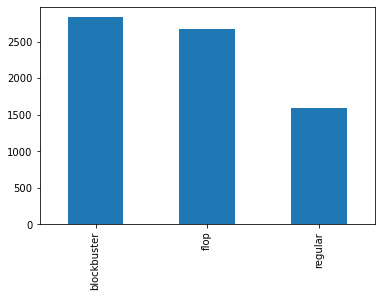

In [472]:
movies['result'].value_counts().plot(kind='bar')

In [473]:
# I wonder if a should adjust this, even has a small frequency - maybe I should just divide 
# into profit/loss?

In [474]:
# now I will hot one encode rating
movies = pd.merge(left = movies, right = pd.get_dummies(movies['rating']), left_index = True, right_index = True)
movies.head()

,story,budget,gross,cumulative,rating,id,startYear,runtimeMinutes,averageRating,numVotes,...,Not Rated,PG,PG-13,R,TV-14,TV-G,TV-MA,TV-PG,Unrated,X
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,1980.0,104,7.1,34936,...,0,0,0,1,0,0,0,0,0,0
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,1980.0,109,5.3,3789,...,0,0,0,1,0,0,0,0,0,0
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,2001.0,118,6.4,78453,...,0,0,1,0,0,0,0,0,0,0
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,1980.0,94,5.2,2988,...,0,1,0,0,0,0,0,0,0,0
5,"In Victorian London, Dr. Frederick Treves with...",5000000,26010864,26021332,PG,tt0080678,1980.0,124,8.1,217572,...,0,1,0,0,0,0,0,0,0,0


In [475]:
#sci-fi was splitted in two, I have to solve this
movies.drop(columns='fi',inplace=True)
movies.rename(columns={'sci':'sci-fi'},inplace = True)
#movies.dtypes

In [476]:
# tables with the average rating of the movies a actor is in, by column
actors1 = pd.pivot_table(movies, values = 'averageRating', index = 'actor1', aggfunc = 'mean')
actors2 = pd.pivot_table(movies, values = 'averageRating', index = 'actor2', aggfunc = 'mean')
actors3 = pd.pivot_table(movies, values = 'averageRating', index = 'actor3', aggfunc = 'mean')

In [477]:
# now for all the movies the actor is credited in any of the top three spots (column actor1,2 or 3)
actors_rating = pd.concat([actors1, actors2, actors3]).groupby(level=0).mean()
actors_rating.head()

,averageRating
,6.827393
nm0000002,6.412500
nm0000004,6.750000
nm0000008,5.961111
nm0000018,6.650000


In [478]:
actors_rating.reset_index(inplace=True)
#actors_rating.head()

In [479]:
# sometimes, a movie doesn't have 1, 2 or 3 actors listed, so I have an entry in my actors 
# rating table without index (actor id)
# I have to drop this
actors_rating.drop(actors_rating.index[0],inplace=True)
#actors_rating.head()

In [480]:
movies.rename(columns={'averageRating': 'avgRt'}, inplace = True)

In [481]:
# I must use a left join merge to get this data into a new column in the movies table
# I have to do it three times, for each of the top three actors
# I'll then calculate the average rating across the three new columns and save it in a column
# called star_rating
print(movies.shape)
movies = pd.merge(left = movies, right = actors_rating, left_on = 'actor1', right_on = 'index', how = 'left')
movies.drop(columns=['index'],inplace=True)
movies = pd.merge(left = movies, right = actors_rating, left_on = 'actor2', right_on = 'index', how = 'left')
movies.drop(columns=['index'],inplace=True)
movies = pd.merge(left = movies, right = actors_rating, left_on = 'actor3', right_on = 'index', how = 'left')
movies.drop(columns=['index'],inplace=True)
print(movies.shape)
movies.head()

(7110, 51)
(7110, 54)


,story,budget,gross,cumulative,rating,id,startYear,runtimeMinutes,avgRt,numVotes,...,R,TV-14,TV-G,TV-MA,TV-PG,Unrated,X,averageRating_x,averageRating_y,averageRating
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,1980.0,104,7.1,34936,...,1,0,0,0,0,0,0,6.607033,7.100000,6.040
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,1980.0,109,5.3,3789,...,1,0,0,0,0,0,0,6.607033,6.225000,5.300
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,2001.0,118,6.4,78453,...,0,0,0,0,0,0,0,6.306667,6.927179,6.325
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,1980.0,94,5.2,2988,...,0,0,0,0,0,0,0,5.200000,5.200000,5.200
4,"In Victorian London, Dr. Frederick Treves with...",5000000,26010864,26021332,PG,tt0080678,1980.0,124,8.1,217572,...,0,0,0,0,0,0,0,6.618875,6.237778,6.400


In [482]:
movies[['actor1','actor2','actor3', 'averageRating_x', 'averageRating_y', 'averageRating']].head()

,actor1,actor2,actor3,averageRating_x,averageRating_y,averageRating
0,nm0000323,nm0001141,nm0000262,6.607033,7.100000,6.040
1,nm0000323,nm0001831,nm0700574,6.607033,6.225000,5.300
2,nm0000212,nm0413168,nm0000630,6.306667,6.927179,6.325
3,nm0010915,nm0397109,nm0000482,5.200000,5.200000,5.200
4,nm0000164,nm0000457,nm0000843,6.618875,6.237778,6.400


In [483]:
def mean_rt(row):
    '''
    takes a row and returns the average of 'averageRating_x', 'averageRating_y', 'averageRating'
    '''
    #i=0
    #s=0
    #if pd.isna(row['averageRating_']) == False:
    #    i+=1
    #    s+=row['averageRating_']
    #if pd.isna(row['averageRatingb']) == False:
    #    i+=1
    #    s+=row['averageRatingb']
    #if pd.isna(row['averageRating']) == False:
    #    i+=1
    #    s+=row['averageRating']
    #if i == 0:
    #    return ''
    #else:
    #    return s/i
    return row[['averageRating_x', 'averageRating_y', 'averageRating']].mean(axis=0)
movies['starsIMDB'] = movies.apply(lambda row: mean_rt(row), axis = 1)

In [484]:
movies.drop(columns=['averageRating_x', 'averageRating_y', 'averageRating'],inplace=True)
movies.head()

,story,budget,gross,cumulative,rating,id,startYear,runtimeMinutes,avgRt,numVotes,...,PG,PG-13,R,TV-14,TV-G,TV-MA,TV-PG,Unrated,X,starsIMDB
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,1980.0,104,7.1,34936,...,0,0,1,0,0,0,0,0,0,6.582344
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,1980.0,109,5.3,3789,...,0,0,1,0,0,0,0,0,0,6.044011
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,2001.0,118,6.4,78453,...,0,1,0,0,0,0,0,0,0,6.519615
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,1980.0,94,5.2,2988,...,1,0,0,0,0,0,0,0,0,5.200000
4,"In Victorian London, Dr. Frederick Treves with...",5000000,26010864,26021332,PG,tt0080678,1980.0,124,8.1,217572,...,1,0,0,0,0,0,0,0,0,6.418884


In [485]:
# now I need the director average IMDB score
directors = pd.pivot_table(movies, values = 'avgRt', index = 'directors', aggfunc='mean')

In [486]:
directors.reset_index(inplace=True)

In [487]:
directors.rename(columns={'directors': 'dirID'}, inplace = True)

In [488]:
print(movies.shape)
movies = pd.merge(left = movies, right = directors, left_on = 'directors', right_on = 'dirID', how = 'left', suffixes = '_a')
#movies.drop(columns=['index'],inplace=True)


(7110, 52)


In [489]:
movies.head()

,story,budget,gross,cumulative,rating,id,startYear,runtimeMinutes,avgRt_,numVotes,...,R,TV-14,TV-G,TV-MA,TV-PG,Unrated,X,starsIMDB,dirID,avgRta
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,1980.0,104,7.1,34936,...,1,0,0,0,0,0,0,6.582344,nm0000361,6.582353
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,1980.0,109,5.3,3789,...,1,0,0,0,0,0,0,6.044011,nm0006916,6.000000
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,2001.0,118,6.4,78453,...,0,0,0,0,0,0,0,6.519615,nm0003506,7.260000
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,1980.0,94,5.2,2988,...,0,0,0,0,0,0,0,5.200000,nm0232795,5.200000
4,"In Victorian London, Dr. Frederick Treves with...",5000000,26010864,26021332,PG,tt0080678,1980.0,124,8.1,217572,...,0,0,0,0,0,0,0,6.418884,nm0000186,7.550000


In [490]:
movies.rename(columns={'avgRta': 'directorIMDB'}, inplace = True)
movies.drop(columns=['dirID'],inplace=True)
movies.head()

,story,budget,gross,cumulative,rating,id,startYear,runtimeMinutes,avgRt_,numVotes,...,PG-13,R,TV-14,TV-G,TV-MA,TV-PG,Unrated,X,starsIMDB,directorIMDB
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,1980.0,104,7.1,34936,...,0,1,0,0,0,0,0,0,6.582344,6.582353
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,1980.0,109,5.3,3789,...,0,1,0,0,0,0,0,0,6.044011,6.000000
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,2001.0,118,6.4,78453,...,1,0,0,0,0,0,0,0,6.519615,7.260000
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,1980.0,94,5.2,2988,...,0,0,0,0,0,0,0,0,5.200000,5.200000
4,"In Victorian London, Dr. Frederick Treves with...",5000000,26010864,26021332,PG,tt0080678,1980.0,124,8.1,217572,...,0,0,0,0,0,0,0,0,6.418884,7.550000


In [491]:
# let's do the same for ROI
# table with the average ROI of the movies a actor is in, by column
actors1 = pd.pivot_table(movies, values = 'ROI', index = 'actor1', aggfunc = 'mean')
actors2 = pd.pivot_table(movies, values = 'ROI', index = 'actor2', aggfunc = 'mean')
actors3 = pd.pivot_table(movies, values = 'ROI', index = 'actor3', aggfunc = 'mean')

In [492]:
# now for all the movies the actor is credited in any of the top three spots (column actor1,2 or 3)
actorsROI = pd.concat([actors1, actors2, actors3]).groupby(level=0).mean()
actorsROI.head()

,ROI
,1.045530
nm0000002,-0.432193
nm0000004,2.893664
nm0000008,0.410970
nm0000018,1.895414


In [493]:
actorsROI.reset_index(inplace=True)
actorsROI.head()

,index,ROI
0,,1.045530
1,nm0000002,-0.432193
2,nm0000004,2.893664
3,nm0000008,0.410970
4,nm0000018,1.895414


In [494]:
# sometimes, a movie doesn't have 1, 2 or 3 actors listed, so I have an entry in my actors 
# rating table without index (actor id)
# I have to drop this
actorsROI.drop(actorsROI.index[0],inplace=True)
actorsROI.rename(columns={'ROI': 'actorROI'}, inplace = True)

In [495]:
# I must use a left join merge to get this data into a new column in the movies table, same logic
# as I used for the IMDB rating
print(movies.shape)
movies = pd.merge(left = movies, right = actorsROI, left_on = 'actor1', right_on = 'index', how = 'left')
movies.drop(columns=['index'],inplace=True)
movies = pd.merge(left = movies, right = actorsROI, left_on = 'actor2', right_on = 'index', how = 'left')
movies.drop(columns=['index'],inplace=True)
movies = pd.merge(left = movies, right = actorsROI, left_on = 'actor3', right_on = 'index', how = 'left')
movies.drop(columns=['index'],inplace=True)
print(movies.shape)
movies.head()

(7110, 53)
(7110, 56)


,story,budget,gross,cumulative,rating,id,startYear,runtimeMinutes,avgRt_,numVotes,...,TV-G,TV-MA,TV-PG,Unrated,X,starsIMDB,directorIMDB,actorROI_x,actorROI_y,actorROI
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,1980.0,104,7.1,34936,...,0,0,0,0,0,6.582344,6.582353,1.160380,3.907538,1.310501
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,1980.0,109,5.3,3789,...,0,0,0,0,0,6.044011,6.000000,1.160380,0.999129,-0.285599
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,2001.0,118,6.4,78453,...,0,0,0,0,0,6.519615,7.260000,1.111353,1.886150,1.286943
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,1980.0,94,5.2,2988,...,0,0,0,0,0,5.200000,5.200000,-0.022531,-0.022531,4.181413
4,"In Victorian London, Dr. Frederick Treves with...",5000000,26010864,26021332,PG,tt0080678,1980.0,124,8.1,217572,...,0,0,0,0,0,6.418884,7.550000,1.207124,0.206723,0.878309


In [496]:
def mean_ROI(row):
    '''
    takes a row and returns the average of 'actorROI_x','actorROI_y','actorROI'
    '''
#    i=0
#    s=0
#    if pd.isna(row['ROIa']) == False:
#        i+=1
#        s+=row['ROIa']
#    if pd.isna(row['ROI_']) == False:
#        i+=1
#        s+=row['ROI_']
#    if pd.isna(row['ROIc']) == False:
#        i+=1
#        s+=row['ROIc']
#    if i == 0:
#        return ''
#    else:
#        return s/i
    return row[['actorROI_x','actorROI_y','actorROI']].mean(axis=0)

movies['starsROI'] = movies.apply(lambda row: mean_ROI(row), axis = 1)
#movies.drop(columns=['ROIa','ROI_','ROIc'],inplace=True)
#movies.head()

In [497]:
movies.drop(columns=['actorROI_x','actorROI_y','actorROI'],inplace=True)

In [498]:
movies.head()

,story,budget,gross,cumulative,rating,id,startYear,runtimeMinutes,avgRt_,numVotes,...,R,TV-14,TV-G,TV-MA,TV-PG,Unrated,X,starsIMDB,directorIMDB,starsROI
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,1980.0,104,7.1,34936,...,1,0,0,0,0,0,0,6.582344,6.582353,2.126140
1,"In New York City, journalist Blair Maynard con...",22000000,15716828,15716828,R,tt0080934,1980.0,109,5.3,3789,...,1,0,0,0,0,0,0,6.044011,6.000000,0.624637
2,Kate and her actor brother live in N.Y. in the...,48000000,47121859,76019048,PG-13,tt0035423,2001.0,118,6.4,78453,...,0,0,0,0,0,0,0,6.519615,7.260000,1.428149
3,An unknown terrorist has developed a new type ...,15000000,14662035,14662035,PG,tt0081249,1980.0,94,5.2,2988,...,0,0,0,0,0,0,0,5.200000,5.200000,1.378784
4,"In Victorian London, Dr. Frederick Treves with...",5000000,26010864,26021332,PG,tt0080678,1980.0,124,8.1,217572,...,0,0,0,0,0,0,0,6.418884,7.550000,0.764052


In [499]:
dirROI = pd.pivot_table(movies, values = 'ROI', index = 'directors', aggfunc='mean')
#movies['ROI']

In [500]:
dirROI.head()

,ROI
directors,
nm0000005,0.132629
nm0000040,1.170849
nm0000041,-0.484156
nm0000091,-0.489186
nm0000095,1.051229


In [501]:
dirROI.reset_index(inplace=True)
dirROI.rename(columns={'directors': 'dirID'}, inplace = True)
dirROI.rename(columns={'ROI': 'dirROI'}, inplace = True)
movies = pd.merge(left = movies, right = dirROI, left_on = 'directors', right_on = 'dirID', how = 'left')

In [502]:
movies.drop(columns=['dirID'],inplace=True)
movies.rename(columns={'dirROI':'directorROI'}, inplace = True)

In [503]:
movies.head(1)

,story,budget,gross,cumulative,rating,id,startYear,runtimeMinutes,avgRt_,numVotes,...,TV-14,TV-G,TV-MA,TV-PG,Unrated,X,starsIMDB,directorIMDB,starsROI,directorROI
0,"While taking a shower, Kate Miller, a middle-a...",6500000,31899000,31899000,R,tt0080661,1980.0,104,7.1,34936,...,0,0,0,0,0,0,6.582344,6.582353,2.12614,0.711566


In [504]:
# Time to decide what to keep
movies.dtypes

story              object
budget              int64
gross               int64
cumulative          int64
rating             object
id                 object
startYear         float64
runtimeMinutes     object
avgRt_            float64
numVotes            int64
directors          object
actor1             object
actor2             object
actor3             object
action              int64
adventure           int64
animation           int64
biography           int64
comedy              int64
crime               int64
documentary         int64
drama               int64
family              int64
fantasy             int64
history             int64
horror              int64
music               int64
musical             int64
mystery             int64
news                int64
romance             int64
sci-fi              int64
sport               int64
thriller            int64
war                 int64
western             int64
ROI               float64
result             object
Approved    

In [505]:
'''
I'll drop: 'rating', 'budget','gross', 'cumulative', 'avgRt_','numVotes', 'fi', 'directors', 'actor1', 'actor2', 'actor3', 'ROI_x' 
Financial data is already taken into account in ROI
the rating is also taken into account at the director and actor agregation/mean
the names/ids of directors and actors cannot be encoded and are useless
My target variable is result, I'll drop ROI
'''
movies.drop(columns = ['rating', 'budget','gross', 'cumulative', 'avgRt_', 'numVotes', 'directors', 'actor1', 'actor2', 'actor3', 'ROI'],inplace=True)

In [506]:
movies.head(1)

,story,id,startYear,runtimeMinutes,action,adventure,animation,biography,comedy,crime,...,TV-14,TV-G,TV-MA,TV-PG,Unrated,X,starsIMDB,directorIMDB,starsROI,directorROI
0,"While taking a shower, Kate Miller, a middle-a...",tt0080661,1980.0,104,0,0,0,0,0,1,...,0,0,0,0,0,0,6.582344,6.582353,2.12614,0.711566


In [507]:
movies.dtypes

story              object
id                 object
startYear         float64
runtimeMinutes     object
action              int64
adventure           int64
animation           int64
biography           int64
comedy              int64
crime               int64
documentary         int64
drama               int64
family              int64
fantasy             int64
history             int64
horror              int64
music               int64
musical             int64
mystery             int64
news                int64
romance             int64
sci-fi              int64
sport               int64
thriller            int64
war                 int64
western             int64
result             object
Approved            uint8
G                   uint8
NC-17               uint8
Not Rated           uint8
PG                  uint8
PG-13               uint8
R                   uint8
TV-14               uint8
TV-G                uint8
TV-MA               uint8
TV-PG               uint8
Unrated     

In [508]:
# 'runtimeMinutes' has the wrong type
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'])
movies['runtimeMinutes'].dtypes

dtype('int64')

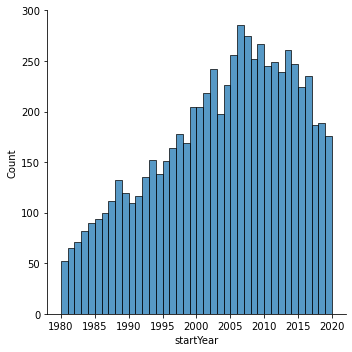

In [509]:
sns.displot(movies, x='startYear', binwidth = 1)

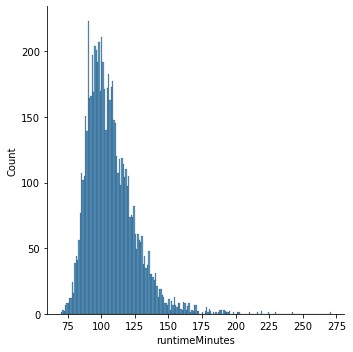

In [510]:
sns.displot(movies, x='runtimeMinutes', binwidth = 1)

In [511]:
# I need to get rid of the outliers here, or they'll screw any standardiztion I may try to do later 
Q1 = movies['runtimeMinutes'].quantile(0.25)
Q3 = movies['runtimeMinutes'].quantile(0.75)
IQR = Q3 - Q1

droppped:  0.006751054852320675


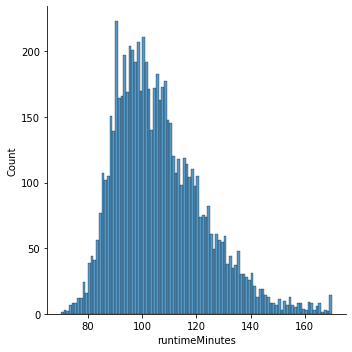

In [512]:
# using the following rule I'll drop less than 1% of my rows, only the very extreme cases
start = movies.shape[0]
movies = movies[movies['runtimeMinutes'] < Q3 + 2.5 * IQR]
print('droppped: ',(start - movies.shape[0]) / start)
sns.displot(movies, x='runtimeMinutes', binwidth = 1)


In [513]:
#encoding categories
movies.loc[movies['result'] == 'blockbuster', 'result'] = 2
movies.loc[movies['result'] == 'flop', 'result'] = 0
movies.loc[movies['result'] == 'regular', 'result'] = 1

In [514]:
# I will now try to build a Naive Bayes for the 'story'

bayes = movies[['story','result']]
bayes.head(1)

,story,result
0,"While taking a shower, Kate Miller, a middle-a...",2


In [417]:
pickle.dump(bayes,open('bayes.pkl',"wb"))

In [65]:
# your code here
#functions
def clean_up(s):
    """
    Cleans up numbers, URLs, and special characters from a string.

    Args:
        s: The string to be cleaned up.

    Returns:
        A string that has been cleaned up.
    """
    # turn to lowercase   
    s = s.lower()
    #remove URLs
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    s = re.sub(regex,"",s)
    #replace special characters with spaces
    s = re.sub(r'([^a-zA-Z ]+?)', ' ', s)
    #removes leading and traling whitespaces
    s = s.strip()
    #removes multiple white spaces
    s = re.sub(' +', ' ', s)
    return s

def tokenize(s):
    """
    Tokenize a string.

    Args:
        s: String to be tokenized.

    Returns:
        A list of words as the result of tokenization.
    """
    #return s.split(" ")
    return nltk.word_tokenize(s)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper() # gets first letter of POS categorization
    tag_dict = {"J": wordnet.ADJ, 
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # get returns second argument if first key does not exist 

def stem_and_lemmatize(l):
    """
    Perform stemming and lemmatization on a list of words.

    Args:
        l: A list of strings.

    Returns:
        A list of strings after being stemmed and lemmatized.
    """
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in l]

def remove_stopwords(l):
    """
    Remove English stopwords from a list of strings.

    Args:
        l: A list of strings.

    Returns:
        A list of strings after stop words are removed.
    """
    return [word for word in l if not word in stopwords.words()]

In [66]:
bayes.head(1)

,story,result
0,"While taking a shower, Kate Miller, a middle-a...",2


In [67]:
# applying functions

def process_text(text):
    '''
    Cleans-up, tokenizes, gets word net position, stems and lemmatizes and then removes the stopwords for a story text.
    Returns the list of resulting 'words'
    '''
    return remove_stopwords(stem_and_lemmatize(tokenize(clean_up(text))))

#bayes['story_processed'] = bayes['story'].apply(process_text)

In [68]:
# The process takes forever, I'm going to save this df

#pickle.dump(bayes,open('bayes_p.pkl',"wb"))

In [242]:
def sound_alert(n_times):
    '''
    sounds an 1s sound alert plus 1s delay n_times
    '''
    duration = 1000  # milliseconds
    freq = 440  # Hz
    for i in range(n_times):
        winsound.Beep(freq, duration)
        time.sleep(1)

In [70]:
#sound_alert(5)

In [71]:
# Load the bayes df with the processed text (I did it on collab, it's faster than my machine)
#bayes = pickle.load(open('bayes_p.pkl',"rb"))

In [516]:
bayes = pd.read_csv('bayes_processed.csv')

In [517]:
bayes.head(1)

,Unnamed: 0,story,result,story_processed
0,0,"While taking a shower, Kate Miller, a middle-a...",2,"['shower', 'kate', 'miller', 'middle', 'age', ..."


In [518]:
bayes['story_processed'].head(1)

0    ['shower', 'kate', 'miller', 'middle', 'age', ...
Name: story_processed, dtype: object

In [519]:
# the lists in text_processed are now strings :(
# let's try to convert them back
from ast import literal_eval

print(bayes.dtypes)
bayes['story_processed'] = bayes['story_processed'].apply(literal_eval)
print(bayes.dtypes)


Unnamed: 0          int64
story              object
result              int64
story_processed    object
dtype: object
Unnamed: 0          int64
story              object
result              int64
story_processed    object
dtype: object


In [520]:
bayes['story_processed'].head(1)

0    [shower, kate, miller, middle, age, sexually, ...
Name: story_processed, dtype: object

In [521]:
#create bag of words in english using sklearn
from nltk.probability import FreqDist

#create a list of all words
all_words=[]
for i in list(bayes.story_processed):
    all_words+=i

#create frequency distribution of all words
fDist = FreqDist(all_words)
top_5000 = fDist.most_common(800) #was 5000
temp = []
for pair in top_5000:
      temp.append(pair[0])
top5000 = temp
len(top5000)

800

In [522]:
# I need this listo to process inputs, let's export it
pickle.dump(top5000,open('top5000.pkl',"wb"))

In [523]:
# we need a function that finds the word features (our top most common words)
# in the text
def find_features(text):
    words = set(text)
    features = {}
    for w in top5000:
        features[w] = (w in words)
    return features

# I need to have this documents numpy array with a list of tuples inside 
documents = bayes[['story_processed','result']]
documents = documents.assign(target=documents['result'])

In [524]:
documents.drop(columns=['result'],inplace=True)

In [525]:
# now to convert my beautifull dataframe into a nightmare of a numpy
documents = list(documents.to_records(index=False))
documents[0]

(list(['shower', 'kate', 'miller', 'middle', 'age', 'sexually', 'frustrate', 'new', 'york', 'city', 'housewife', 'rape', 'fantasy', 'husband', 'stand', 'sink', 'shave', 'later', 'day', 'complain', 'psychiatrist', 'dr', 'robert', 'elliott', 'husband', 'pathetic', 'performance', 'bed', 'meet', 'strange', 'museum', 'return', 'apartment', 'continue', 'adulterous', 'encounter', 'begin', 'taxicab', 'leaf', 'apartment', 'find', 'paper', 'certify', 'venereal', 'disease', 'panicked', 'kate', 'rush', 'elevator', 'return', 'apartment', 'realizes', 'forgotten', 'wedding', 'ring', 'elevator', 'open', 'brutally', 'slash', 'death', 'tall', 'blonde', 'woman', 'wear', 'dark', 'sunglass', 'liz', 'blake', 'high', 'class', 'call', 'girl', 'witness', 'murder', 'becomes', 'prime', 'suspect', 'murderer', 'next', 'target', 'liz', 'rescue', 'kill', 'kate', 'enlists', 'help', 'liz', 'catch', 'mother']), 2)

In [526]:
# finally we do what we really want to do
featuresets = [(find_features(text), target) for (text, target) in documents]

In [527]:
len(featuresets)

7062

In [528]:
# split feature set into a training and a test set. 
training_set = featuresets[:6355]
testing_set = featuresets[6355:]

# create a Bayes classifier instance using nltk.NaiveBayesClassifier.train
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [529]:
# test our classifier with the test dataset
print("Naive Bayes Algo accuracy:", (nltk.classify.accuracy(classifier, testing_set))*100)

Naive Bayes Algo accuracy: 49.36350777934936


In [530]:
# saving our model, just in case
pickle.dump(classifier,open('NBClassifier.pkl',"wb"))

In [531]:
# example
classifier.classify(featuresets[0][0])

2

In [532]:
featuresets[0][0]

{'life': False,
 'find': True,
 'get': False,
 'new': True,
 'year': False,
 'friend': False,
 'go': False,
 'young': False,
 'family': False,
 'love': False,
 'two': False,
 'make': False,
 'world': False,
 'time': False,
 'father': False,
 'old': False,
 'work': False,
 'try': False,
 'help': True,
 'woman': True,
 'story': False,
 'day': True,
 'must': False,
 'back': False,
 'way': False,
 'school': False,
 'mother': True,
 'home': False,
 'know': False,
 'wife': False,
 'meet': True,
 'kill': True,
 'turn': False,
 'begin': True,
 'however': False,
 'girl': True,
 'lead': False,
 'become': False,
 'town': False,
 'city': True,
 'see': False,
 'force': False,
 'daughter': False,
 'first': False,
 'brother': False,
 'set': False,
 'soon': False,
 'high': True,
 'start': False,
 'job': False,
 'team': False,
 'child': False,
 'house': False,
 'call': True,
 'fall': False,
 'boy': False,
 'becomes': True,
 'murder': True,
 'return': True,
 'death': True,
 'together': False,
 'night': 

In [533]:
# prediction for all cases (really slow!)
classifications = [classifier.classify(fs[0]) for fs in featuresets]
sound_alert(2)

In [534]:
#it is likely an array so I need to convert it first
classifications = pd.DataFrame(classifications, columns=['NLPclass']) 

In [535]:
len(classifications)

7062

In [536]:
classifications[-10:]

,NLPclass
7052,0
7053,0
7054,1
7055,2
7056,0
7057,0
7058,1
7059,2
7060,2
7061,2


In [537]:
#the indexes don't match (because of all the dropped rows in movies), i have to reset the movies
movies.reset_index(inplace=True)

In [538]:
# The order is the same as the original df (movies)
movies['NLPclass'] = classifications

In [539]:
movies[movies['NLPclass'].isna()]

,index,story,id,startYear,runtimeMinutes,action,adventure,animation,biography,comedy,...,TV-G,TV-MA,TV-PG,Unrated,X,starsIMDB,directorIMDB,starsROI,directorROI,NLPclass


In [540]:
movies.head(3)

,index,story,id,startYear,runtimeMinutes,action,adventure,animation,biography,comedy,...,TV-G,TV-MA,TV-PG,Unrated,X,starsIMDB,directorIMDB,starsROI,directorROI,NLPclass
0,0,"While taking a shower, Kate Miller, a middle-a...",tt0080661,1980.0,104,0,0,0,0,0,...,0,0,0,0,0,6.582344,6.582353,2.126140,0.711566,2
1,1,"In New York City, journalist Blair Maynard con...",tt0080934,1980.0,109,1,1,0,0,0,...,0,0,0,0,0,6.044011,6.000000,0.624637,1.069278,2
2,2,Kate and her actor brother live in N.Y. in the...,tt0035423,2001.0,118,0,0,0,0,1,...,0,0,0,0,0,6.519615,7.260000,1.428149,2.133956,1


## Time to create the final classifier model
I'm aiming to use a gradient boost classifier

In [541]:
# I no longer need the story column, nor the id
movies.drop(columns=['story','id'],inplace=True)

In [542]:
movies['result'] = pd.to_numeric(movies['result'])

In [543]:
# I have to drop the index
movies.drop(columns='index',inplace=True)

In [544]:
movies.dtypes

startYear         float64
runtimeMinutes      int64
action              int64
adventure           int64
animation           int64
biography           int64
comedy              int64
crime               int64
documentary         int64
drama               int64
family              int64
fantasy             int64
history             int64
horror              int64
music               int64
musical             int64
mystery             int64
news                int64
romance             int64
sci-fi              int64
sport               int64
thriller            int64
war                 int64
western             int64
result              int64
Approved            uint8
G                   uint8
NC-17               uint8
Not Rated           uint8
PG                  uint8
PG-13               uint8
R                   uint8
TV-14               uint8
TV-G                uint8
TV-MA               uint8
TV-PG               uint8
Unrated             uint8
X                   uint8
starsIMDB   

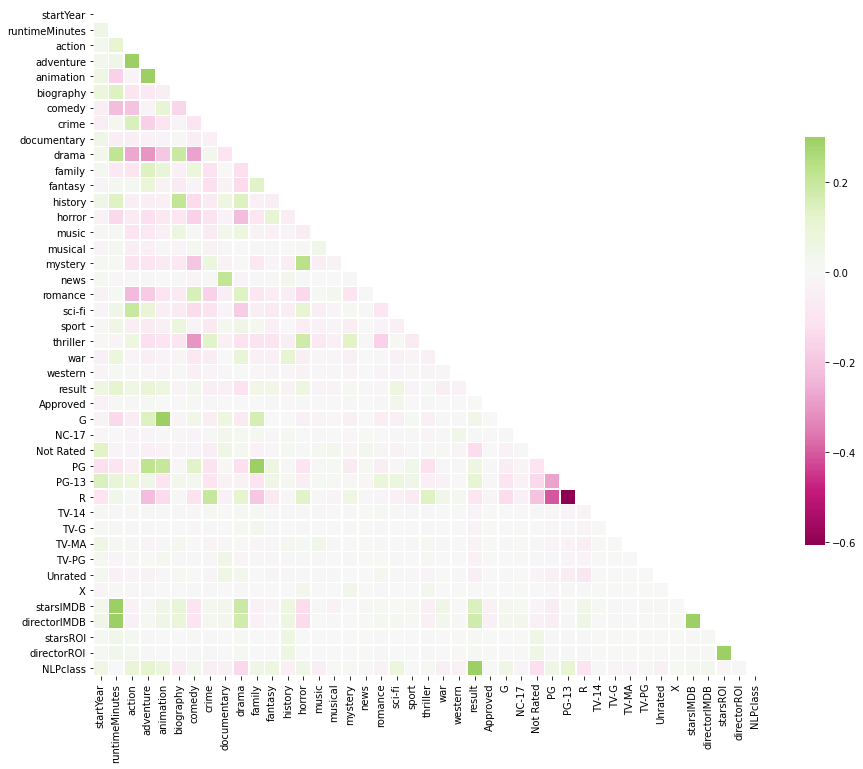

In [545]:
movies_corr = movies.corr()
mask = np.triu(np.ones_like(movies_corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(movies_corr, mask=mask,annot=False, cmap="PiYG", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [546]:
from sklearn.model_selection import train_test_split
X = movies.drop('result', axis=1)
y = movies['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 1)

In [547]:
# optimization by hand
model = XGBClassifier(#silent=False, 
                        #scale_pos_weight=1,
                        learning_rate=0.01, #c  
                        colsample_bytree = .84, #c
                        subsample = 0.8, #c
                        # objective='binary:logistic', 
                        n_estimators=700, #c 
                        #reg_alpha = 0.3,
                        max_depth=5, #c 
                        gamma=1)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(score)

0.7652050919377652


In [548]:
model.predict(X_train.iloc[:2])

array([2, 0], dtype=int64)

In [549]:
# saving our best model so far, just in case
pickle.dump(model,open('XGBClassifier.pkl',"wb"))

Confusion matrix, without normalization
[[217  35  28]
 [ 26  69  48]
 [  4  25 255]]
Normalized confusion matrix
[[0.775      0.125      0.1       ]
 [0.18181818 0.48251748 0.33566434]
 [0.01408451 0.08802817 0.89788732]]


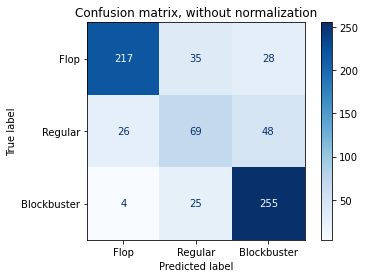

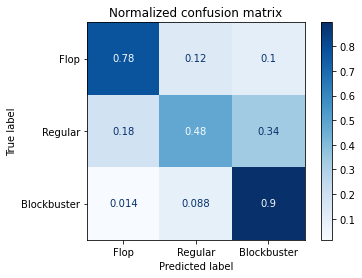

In [555]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=['Flop','Regular','Blockbuster'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [554]:
from sklearn import svm, datasets
iris = datasets.load_iris()
class_names = iris.target_names
class_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [552]:
model.accuracy_score(X_test, y_test)

AttributeError: 'XGBClassifier' object has no attribute 'accuracy_score'

In [260]:
# grid for grid search
grid = {"learning_rate"    : [ 0.01, 0.05, 0.10, 0.15, 0.2 ] ,
        "max_depth"        : [ 3, 4, 5, 6, 8, 10 ],
        "min_child_weight" : [ 1, 3, 5, 7 ],
        "gamma"            : [ 0.0, 0.1, 0.5, 1, 1.5 ],
        "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 0.85 ] }

In [ ]:
from sklearn.model_selection import GridSearchCV
GS_model = XGBClassifier()
grid_search = GridSearchCV(estimator = GS_model, param_grid = grid, cv = 3, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [261]:
params={'colsample_bytree': 0.7,
        'gamma': 0.1,
        'learning_rate': 0.1,
        'max_depth': 4,
        'min_child_weight': 3}
GS_model = XGBClassifier(params)
GS_model.fit(X_train, y_train)
GS_model.score(X_test, y_test)

0.7326732673267327

In [454]:
#Random Search
from sklearn.model_selection import RandomizedSearchCV

params = {"learning_rate"    : [ 0.01 ] ,
          "max_depth"        : [ 6, 7 ],
          "min_child_weight" : [ 6, 8, 9 ],
          "subsample"        : [ 0.8] ,
          "gamma"            : [ 0.1, 0.5, 1 ] ,
          "colsample_bytree" : [ 0.4, 0.5 , 0.8 ] ,
          "n_estimators"     : [ 800, 1000 ] }
random_search = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions=params, n_iter=100,
                                   n_jobs=-1, verbose=3, random_state=0 )
random_search.fit(X_train,y_train)
print(random_search.best_params_)
print(random_search.best_score_)
sound_alert(1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 10.8min


KeyboardInterrupt: 

In [323]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

model = GradientBoostingRegressor()
parameters = {'learning_rate': sp_randFloat(),
              'subsample'    : sp_randFloat(),
              'n_estimators' : sp_randInt(100, 1000),
              'max_depth'    : sp_randInt(4, 10) 
                 }
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
                          cv=10, n_iter=20, n_jobs=-1)
randm.fit(X_train, y_train)

#Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n", randm.best_estimator_)
print("\n The best score across ALL searched params:\n", randm.best_score_)    
print("\n The best parameters across ALL searched params:\n", randm.best_params_)
print("\n ========================================================")


 Results from Random Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.05780952924779925, max_depth=6,
                          n_estimators=120, subsample=0.39974378416709333)

 The best score across ALL searched params:
 0.5596458552116106

 The best parameters across ALL searched params:
 {'learning_rate': 0.05780952924779925, 'max_depth': 6, 'n_estimators': 120, 'subsample': 0.39974378416709333}



In [325]:
# https://towardsdatascience.com/how-to-improve-the-performance-of-xgboost-models-1af3995df8ad